# Correlation between gradient-based saliency and human fixations

In [1]:
from analysis import *

task = "wiki"
tuned = "finetuned"
df = read_data(tuned, task)
fintuned_df = get_corr(df)
generate_tex(fintuned_df)

             Mean  Standard Error
BERT_BASE   0.526           0.010
BERT_Large  0.521           0.009
RoBERTa     0.422           0.010
DistilBERT  0.448           0.010
GPT2        0.460           0.010
GPT2_Large  0.520           0.009
OPT         0.500           0.011


In [6]:
tuned = "pretrained"
df = read_data(tuned, task)
pretrained_df = get_corr(df)
generate_tex(pretrained_df)

             Mean  Standard Error
BERT_BASE   0.509           0.010
BERT_Large  0.473           0.011
RoBERTa     0.365           0.011
DistilBERT  0.485           0.010
GPT2        0.365           0.011
GPT2_Large  0.452           0.011
OPT         0.423           0.011


In [7]:
tuned = "random"
seeds = [str(i) for i in range(1, 3)]

df = read_data(tuned, task)
random_df = get_corr(df)

for seed in seeds:
    tmp_df = read_data(f"random{seed}", task)
    tmp_corr_df = get_corr(tmp_df)
    for key in random_df:
        random_df[key] += tmp_corr_df[key]

for key in random_df:
    random_df[key] = [x / (len(seeds) + 1) for x in random_df[key]]

generate_tex(random_df)

             Mean  Standard Error
BERT_BASE   0.083           0.011
BERT_Large  0.067           0.011
RoBERTa     0.036           0.012
DistilBERT  0.087           0.011
GPT2        0.155           0.013
GPT2_Large  0.157           0.013
OPT         0.140           0.014


In [9]:
# for each column in the dataframe, do a t-test
import scipy.stats as stats
for col in fintuned_df.columns:
    print(col, end=" ")
    print(stats.ttest_ind(pretrained_df[col], fintuned_df[col]))

bert TtestResult(statistic=-1.2785968602810676, pvalue=0.20148309356619767, df=668.0)
bert_large TtestResult(statistic=-3.343940342303413, pvalue=0.0008721237749184067, df=668.0)
roberta TtestResult(statistic=-3.7670208037811137, pvalue=0.00017978958510583075, df=668.0)
distilbert TtestResult(statistic=2.5924236515094083, pvalue=0.009738700852220434, df=668.0)
gpt2 TtestResult(statistic=-6.5772320593337925, pvalue=9.6767864015747e-11, df=668.0)
gpt2_large TtestResult(statistic=-4.774937870741067, pvalue=2.2104758621846334e-06, df=668.0)
opt TtestResult(statistic=-4.975236744252222, pvalue=8.298620111793002e-07, df=668.0)


# Participant-level correlation 

sst
& 0.44 & 0.33 & 0.26 & 0.37 & 0.37 & 0.34 & 0.36 & 0.38 & 0.48 & 0.46 & 0.39 & 0.36 avg:  0.3781360863347097
wiki
& 0.37 & 0.27 & 0.26 & 0.33 & 0.41 & 0.34 & 0.31 & 0.43 & 0.42 & 0.36 & 0.22 avg:  0.33877186470482945


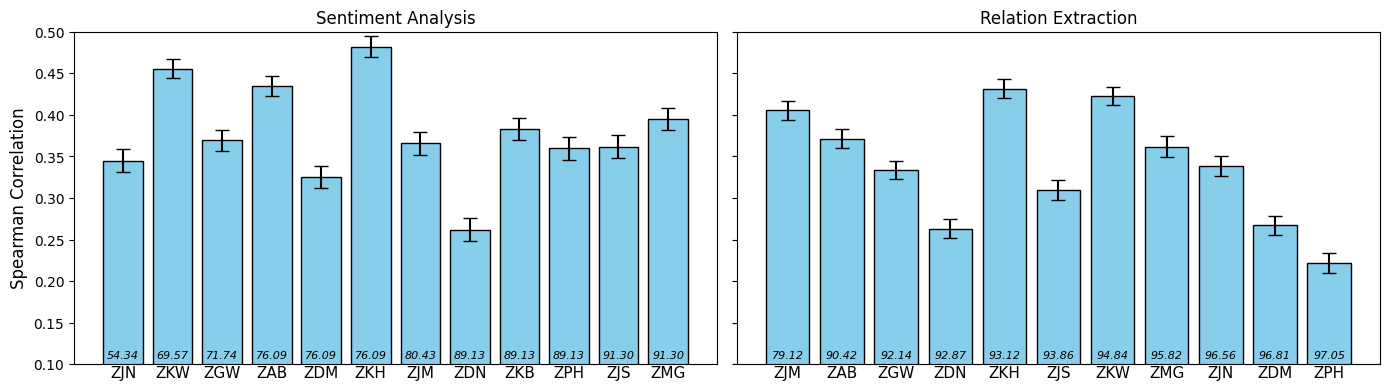

In [1]:
from analysis import *
task_names = ["sst", "wiki"] 
model_name = "bert_large"
for task in task_names:
    subject_analysis(task, model_name)
draw_subject_barplot(task_names, model_name)